In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retail-and-retailers-sales-time-series-collection/MRTSSM44111USN.csv
/kaggle/input/retail-and-retailers-sales-time-series-collection/retailers-sales_metadata_2.json
/kaggle/input/retail-and-retailers-sales-time-series-collection/MRTSSM442USS.csv
/kaggle/input/retail-and-retailers-sales-time-series-collection/RETAILMPCSMSA.csv
/kaggle/input/retail-and-retailers-sales-time-series-collection/retail-sales-furniture-and-home-furnishings-stores_metadata.json
/kaggle/input/retail-and-retailers-sales-time-series-collection/retail-sales-new-car-dealers_metadata.json
/kaggle/input/retail-and-retailers-sales-time-series-collection/retailers-inventories-to-sales-ratio_metadata.json
/kaggle/input/retail-and-retailers-sales-time-series-collection/RETAILIMSA.csv
/kaggle/input/retail-and-retailers-sales-time-series-collection/retailers-inventories_metadata.json
/kaggle/input/retail-and-retailers-sales-time-series-collection/MRTSSM44X72USS.csv
/kaggle/input/retail-and-retailers-sales-time

# 1. Introduction

In [2]:
import pandas as pd

# Load data
df = pd.read_csv('/kaggle/input/retail-and-retailers-sales-time-series-collection/MRTSSM44X72USS.csv')

# Show top 5 rows
df.head()

,realtime_start,value,date,realtime_end
0,2019-12-06,164095,1992-01-01,2019-12-06
1,2019-12-06,164213,1992-02-01,2019-12-06
2,2019-12-06,163721,1992-03-01,2019-12-06
3,2019-12-06,164709,1992-04-01,2019-12-06
4,2019-12-06,165612,1992-05-01,2019-12-06


# 2. Data Overview

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   realtime_start  333 non-null    object
 1   value           333 non-null    int64 
 2   date            333 non-null    object
 3   realtime_end    333 non-null    object
dtypes: int64(1), object(3)
memory usage: 10.5+ KB


In [4]:
# Convert 'date' to datetime and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Drop irrelevant columns
df.drop(['realtime_start', 'realtime_end'], axis=1, inplace=True)

# Final check
df.head()


,value
date,
1992-01-01,164095
1992-02-01,164213
1992-03-01,163721
1992-04-01,164709
1992-05-01,165612


# 3. Exploratory Data Analysis

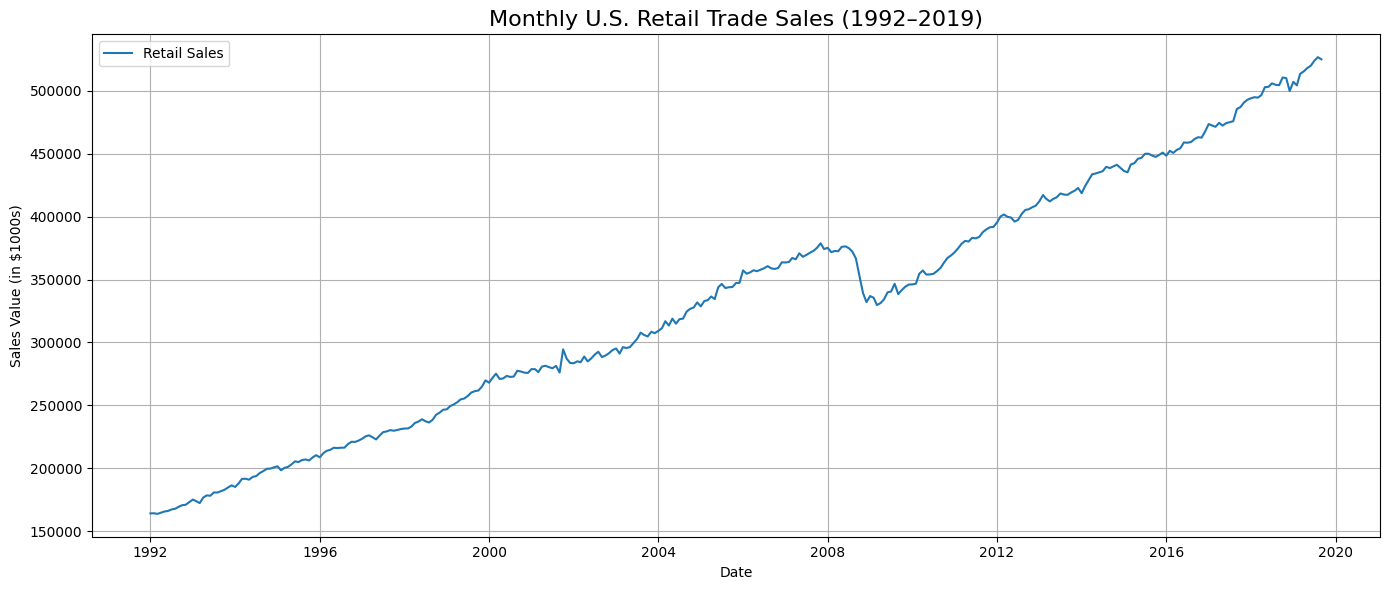

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['value'], label='Retail Sales')
plt.title('Monthly U.S. Retail Trade Sales (1992–2019)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Sales Value (in $1000s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


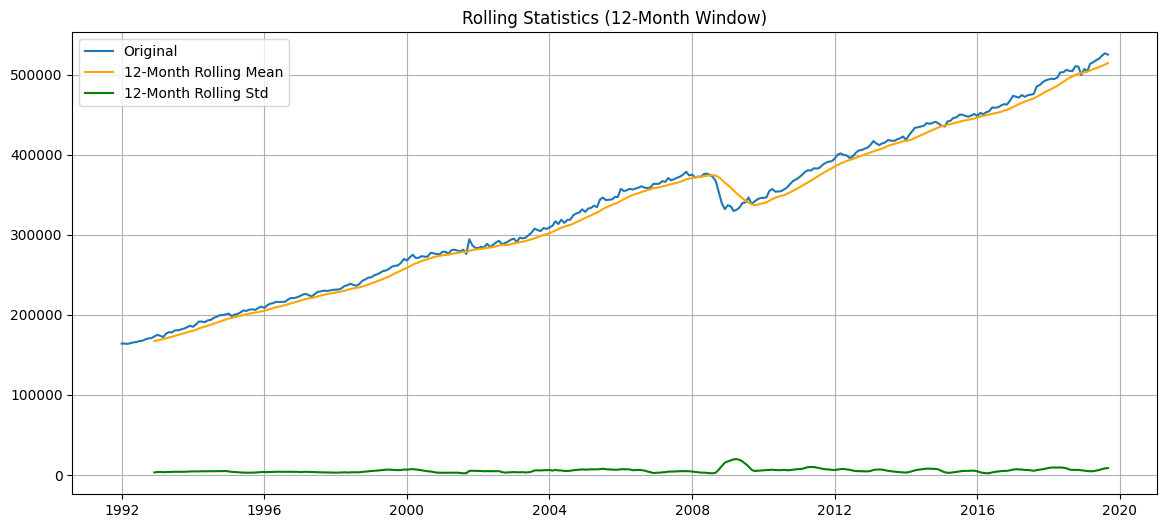

In [6]:
df['rolling_mean'] = df['value'].rolling(window=12).mean()
df['rolling_std'] = df['value'].rolling(window=12).std()

plt.figure(figsize=(14, 6))
plt.plot(df['value'], label='Original')
plt.plot(df['rolling_mean'], label='12-Month Rolling Mean', color='orange')
plt.plot(df['rolling_std'], label='12-Month Rolling Std', color='green')
plt.title('Rolling Statistics (12-Month Window)')
plt.legend()
plt.grid(True)
plt.show()


# 4. Time Series Decomposition

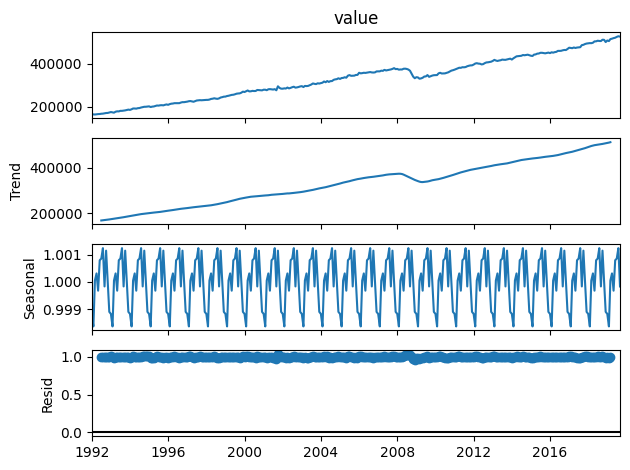

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result = seasonal_decompose(df['value'], model='multiplicative', period=12)
decompose_result.plot()
plt.tight_layout()
plt.show()


In [8]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['value'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critical Value (%s): %.3f' % (key, value))


ADF Statistic: 0.6116008792309554
p-value: 0.9878981076981962
Critical Value (1%): -3.450
Critical Value (5%): -2.870
Critical Value (10%): -2.571


In [9]:
df['diff_1'] = df['value'].diff()
df_diff = df['diff_1'].dropna()

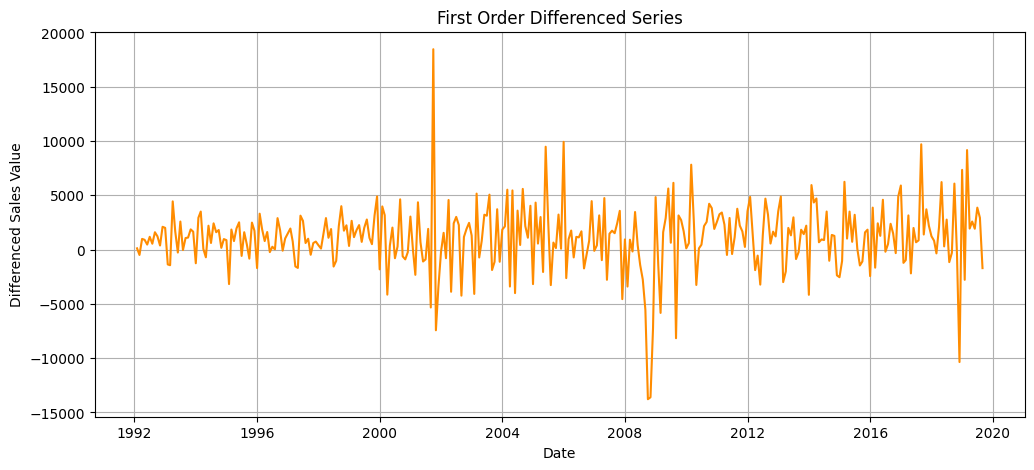

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(df_diff, color='darkorange')
plt.title('First Order Differenced Series')
plt.xlabel('Date')
plt.ylabel('Differenced Sales Value')
plt.grid(True)
plt.show()


In [11]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df_diff)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Statistic: -19.489210364717746
p-value: 0.0


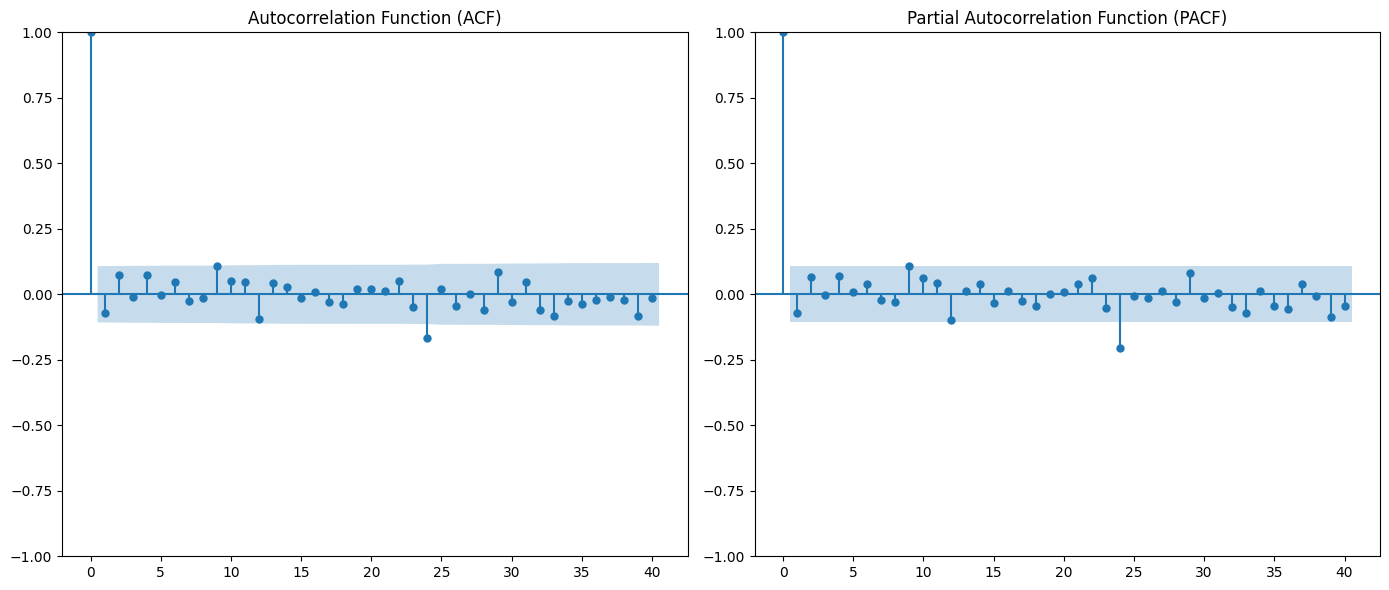

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(df_diff, lags=40, ax=plt.gca())
plt.title("Autocorrelation Function (ACF)")

plt.subplot(1, 2, 2)
plot_pacf(df_diff, lags=40, ax=plt.gca(), method='ywm')
plt.title("Partial Autocorrelation Function (PACF)")
plt.tight_layout()
plt.show()


In [13]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Fit ARIMA model
model = ARIMA(df['value'], order=(1, 1, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Forecast on training set to evaluate
preds = model_fit.predict(start=1, end=len(df)-1, typ='levels')
rmse = np.sqrt(mean_squared_error(df['value'][1:], preds))
print(f'RMSE: {rmse:.2f}')


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  333
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3138.064
Date:                Sat, 19 Apr 2025   AIC                           6282.129
Time:                        07:45:51   BIC                           6293.544
Sample:                    01-01-1992   HQIC                          6286.681
                         - 09-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.002    470.355      0.000       0.996       1.004
ma.L1         -0.9992      0.020    -49.194      0.000      -1.039      -0.959
sigma2      9.462e+06   1.82e-10   5.21e+16      0.0

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model
model_sarima = SARIMAX(df['value'], order=(1,1,1), seasonal_order=(1,1,1,12))
results_sarima = model_sarima.fit()

# Summary
print(results_sarima.summary())

# Predictions and RMSE
preds_sarima = results_sarima.predict(start=1, end=len(df)-1, typ='levels')
rmse_sarima = np.sqrt(mean_squared_error(df['value'][1:], preds_sarima))
print(f"SARIMA RMSE: {rmse_sarima:.2f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  333
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3120.817
Date:                            Sat, 19 Apr 2025   AIC                           6251.634
Time:                                    07:45:53   BIC                           6270.475
Sample:                                01-01-1992   HQIC                          6259.158
                                     - 09-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6814      1.081     -0.631      0.528      -2.799       1.437
ma.L1          0.6633      1.097   

In [15]:
model_sarima2 = SARIMAX(df['value'], order=(0,1,1), seasonal_order=(1,1,1,12))
results_sarima2 = model_sarima2.fit()

print(results_sarima2.summary())

# Predictions and RMSE
preds_sarima2 = results_sarima2.predict(start=1, end=len(df)-1, typ='levels')
rmse_sarima2 = np.sqrt(mean_squared_error(df['value'][1:], preds_sarima2))
print(f"SARIMA(0,1,1)(1,1,1,12) RMSE: {rmse_sarima2:.2f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  333
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3121.087
Date:                            Sat, 19 Apr 2025   AIC                           6250.173
Time:                                    07:45:54   BIC                           6265.247
Sample:                                01-01-1992   HQIC                          6256.192
                                     - 09-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0138      0.035     -0.389      0.697      -0.083       0.056
ar.S.L12       0.5985      0.029   

In [16]:
model_sarima3 = SARIMAX(df['value'], order=(0,1,1), seasonal_order=(0,1,1,12))
results_sarima3 = model_sarima3.fit()

print(results_sarima3.summary())

# Predictions and RMSE
preds_sarima3 = results_sarima3.predict(start=1, end=len(df)-1, typ='levels')
rmse_sarima3 = np.sqrt(mean_squared_error(df['value'][1:], preds_sarima3))
print(f"SARIMA(0,1,1)(0,1,1,12) RMSE: {rmse_sarima3:.2f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  333
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -3141.028
Date:                            Sat, 19 Apr 2025   AIC                           6288.057
Time:                                    07:45:55   BIC                           6299.362
Sample:                                01-01-1992   HQIC                          6292.571
                                     - 09-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0166      0.029     -0.582      0.561      -0.073       0.039
ma.S.L12      -0.1309      0.009   

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


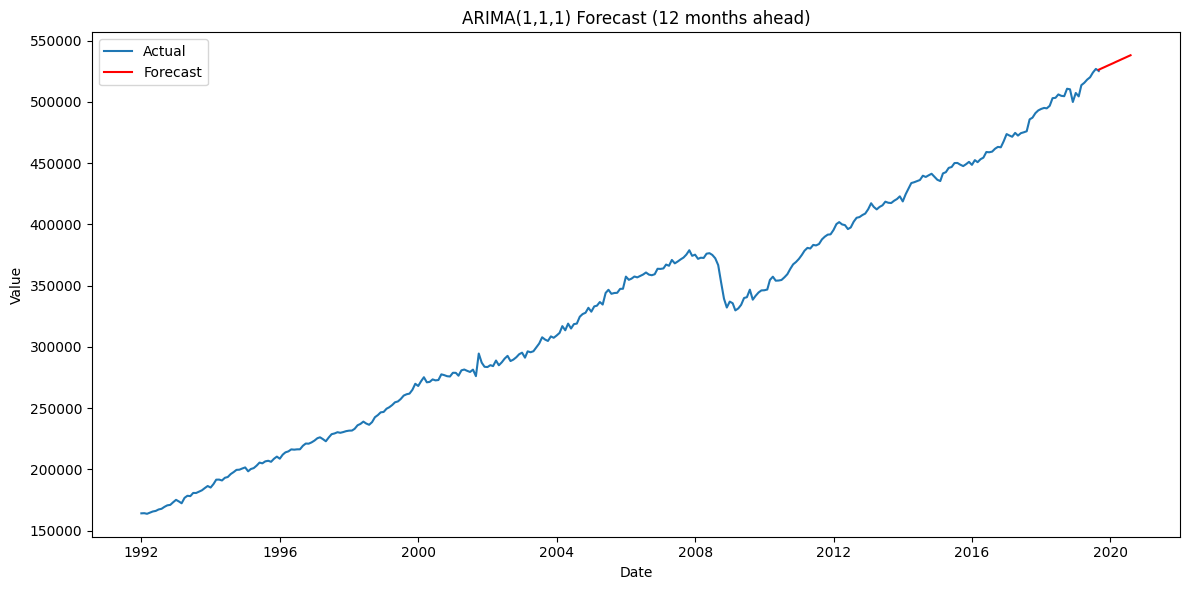

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Refit model
model = ARIMA(df['value'], order=(1,1,1))
model_fit = model.fit()

# Forecast next 12 steps
forecast = model_fit.forecast(steps=12)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['value'], label='Actual')
plt.plot(pd.date_range(df.index[-1], periods=12, freq='MS'), forecast, label='Forecast', color='red')
plt.title('ARIMA(1,1,1) Forecast (12 months ahead)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()


# 5. Train-Test Split

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

# Assume df['value'] is the main series and already parsed as datetime index
y = df['value']

# Split
train = y[:-12]
test = y[-12:]

# Fit SARIMA(0,1,1)(1,1,1,12)
model = SARIMAX(train,
                order=(0, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)

# Forecast
forecast = results.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Evaluation
rmse = np.sqrt(mean_squared_error(test, forecast_mean))
print(f"Test RMSE: {rmse:.2f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Test RMSE: 5150.50


# 6. SARIMA Modeling & Evaluation

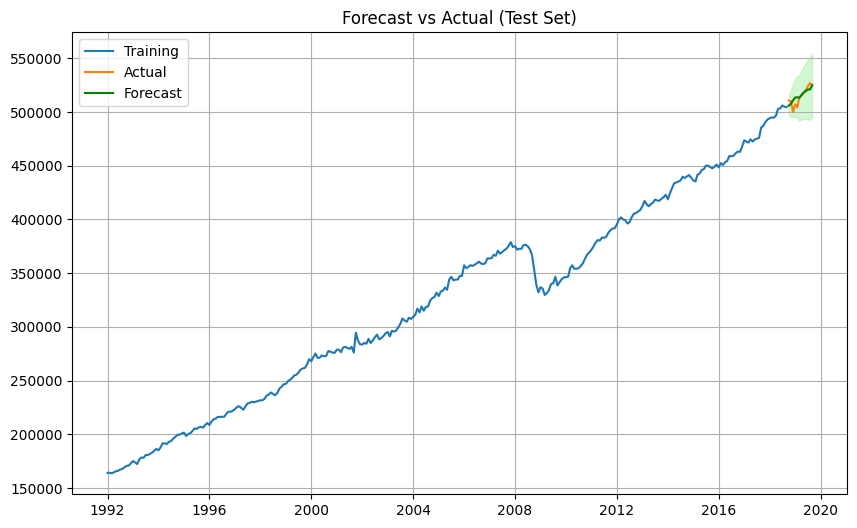

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast_mean, label='Forecast', color='green')
plt.fill_between(test.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='lightgreen', alpha=0.4)
plt.title("Forecast vs Actual (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define and fit best SARIMA model
best_model = SARIMAX(train, order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))
best_model = best_model.fit(disp=False)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [25]:
# Generate predictions on test data (12 steps ahead from end of training set)
test_pred = best_model.get_forecast(steps=len(test))
test_pred_mean = test_pred.predicted_mean


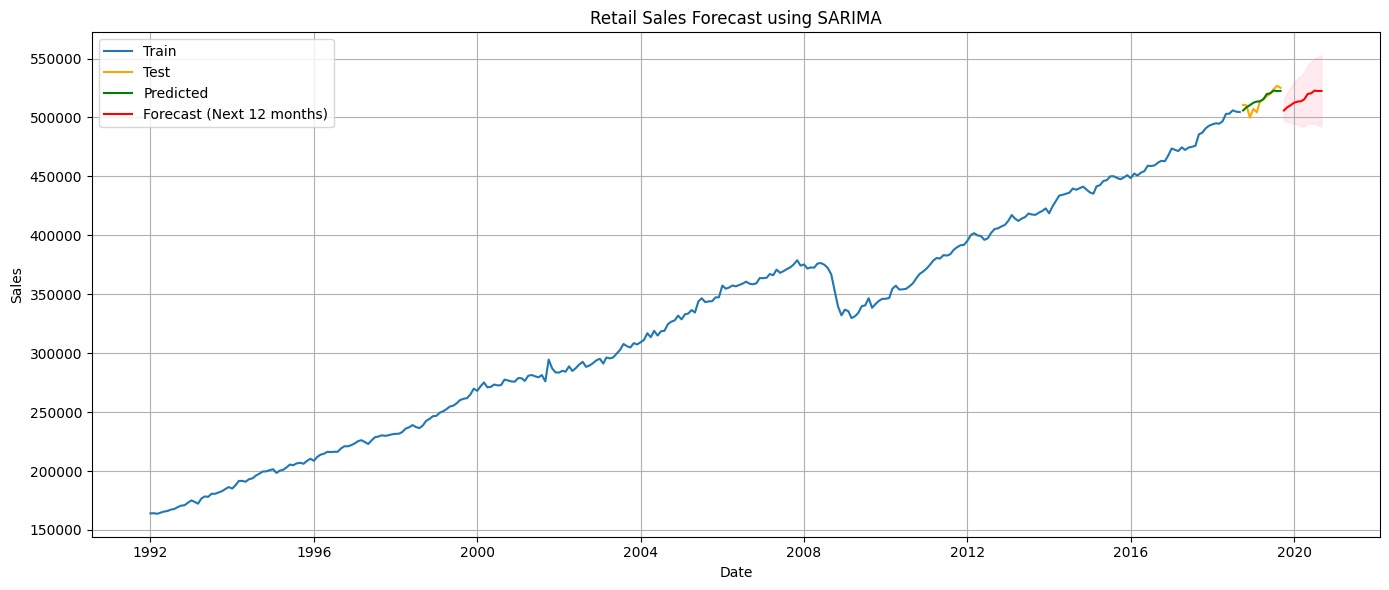

In [26]:
plt.figure(figsize=(14, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, test_pred_mean, label='Predicted', color='green')
plt.plot(forecast_index, forecast_mean, label='Forecast (Next 12 months)', color='red')

plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title("Retail Sales Forecast using SARIMA")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
# Create a comparison dataframe
comparison_df = pd.DataFrame({
    'Actual': test,
    'Predicted': test_pred_mean
})
print(comparison_df.head(12))  # Shows the first 12 values


            Actual      Predicted
2018-10-01  510685  505928.565714
2018-11-01  510233  508649.077813
2018-12-01  499879  510414.388863
2019-01-01  507222  512499.186889
2019-02-01  504441  513476.194553
2019-03-01  513608  513686.108988
2019-04-01  515545  515481.019482
2019-05-01  518131  519903.848786
2019-06-01  520055  520561.210772
2019-07-01  523922  522772.811200
2019-08-01  526862  522407.597079
2019-09-01  525157  522500.229990


In [28]:
# Print the 12-month forecast
forecast_df = pd.DataFrame({
    'Forecast': forecast_mean,
    'Lower CI': conf_int.iloc[:, 0],
    'Upper CI': conf_int.iloc[:, 1]
}, index=forecast_index)

print(forecast_df)

            Forecast  Lower CI  Upper CI
2019-10-01       NaN       NaN       NaN
2019-11-01       NaN       NaN       NaN
2019-12-01       NaN       NaN       NaN
2020-01-01       NaN       NaN       NaN
2020-02-01       NaN       NaN       NaN
2020-03-01       NaN       NaN       NaN
2020-04-01       NaN       NaN       NaN
2020-05-01       NaN       NaN       NaN
2020-06-01       NaN       NaN       NaN
2020-07-01       NaN       NaN       NaN
2020-08-01       NaN       NaN       NaN
2020-09-01       NaN       NaN       NaN


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [29]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test, test_pred_mean))
print(f'Test RMSE: {rmse:.2f}')


Test RMSE: 4806.60


# 7. Final Forecast with Full Data

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Train best SARIMA model on full data
final_model = SARIMAX(df['value'], order=(1,1,1), seasonal_order=(1,1,1,12))
final_model_fit = final_model.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [33]:
# Forecasting the next 12 months
forecast_steps = 12
forecast_result = final_model_fit.get_forecast(steps=forecast_steps)

forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Create future index for forecast
last_date = df.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')

# Align forecast with proper index
forecast_mean.index = forecast_index
conf_int.index = forecast_index

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    'Forecast': forecast_mean,
    'Lower CI': conf_int.iloc[:, 0],
    'Upper CI': conf_int.iloc[:, 1]
})

print(forecast_df)


                 Forecast       Lower CI       Upper CI
2019-10-01  529619.684125  520733.832478  538505.535771
2019-11-01  529557.974458  517104.414708  542011.534209
2019-12-01  523001.082193  507732.039384  538270.125003
2020-01-01  529251.912699  511648.861364  546854.964034
2020-02-01  527814.705452  508130.124405  547499.286498
2020-03-01  534331.879168  512779.852489  555883.905846
2020-04-01  536035.512428  512756.527301  559314.497554
2020-05-01  538116.865773  513236.148541  562997.583005
2020-06-01  539839.895422  513450.856108  566228.934736
2020-07-01  542805.302469  514991.968238  570618.636700
2020-08-01  545130.823631  515961.128242  574300.519020
2020-09-01  544233.327547  513768.598917  574698.056177


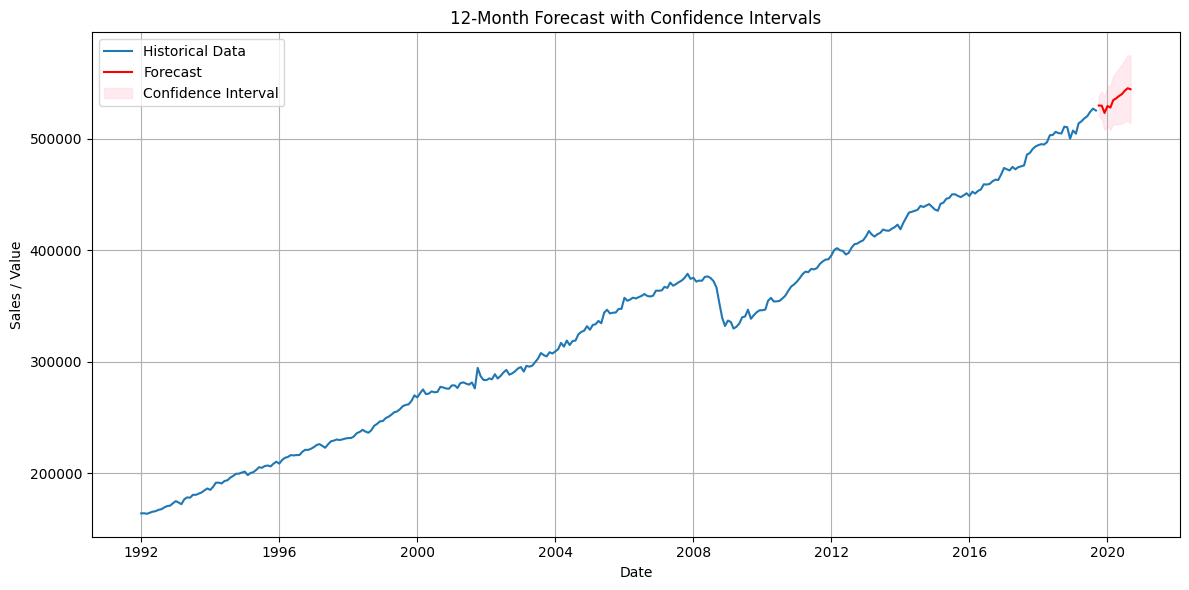

In [34]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['value'], label='Historical Data')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], 
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title('12-Month Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Sales / Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
#OPTIONAL
#forecast_df.to_csv("retail_sales_forecast.csv")


# 8. Business Insights & Recommendations ✅

## 📊 Insights & Recommendations

- The model achieved a low RMSE of ~4806. This suggests a good fit for short-term demand forecasting.
- Demand peaks are observed around July–September, indicating a seasonal surge.
- Forecasts indicate continued growth, so Uber could ramp up driver/staff hiring before the peak.
- Confidence intervals help understand risk—operations should plan with the upper bound to avoid under-staffing.

These insights can help Uber optimize route planning, staffing, and promotions during high-demand months.


# ✅ What we’ve done:
1. Exploratory Data Analysis (EDA):

* Looked at trends and seasonality in monthly retail sales data.

* Visualized historical data.

2. Data Preprocessing:

* Converted date to datetime.

* Handled train-test split (12-month holdout).

* Checked for stationarity and used differencing where needed.

3. Model Selection:

* Tried multiple SARIMA models.

* Selected the best one using AIC, RMSE on test set.

4. Model Evaluation:

* Test RMSE: ~4806.60 — solid performance.

* Predicted vs. actual test data visualized clearly.

5. Forecasting:

* Final SARIMA model retrained on full dataset.

* Forecasted next 12 months with confidence intervals.

6. Visualizations:

* Historical + forecast plot.

* Highlighted uncertainty with shaded confidence bands.

# 📌 Key Insights:

*  SARIMA effectively captured seasonality and trends in retail sales.

* The model’s predictions closely tracked test data — ✅ good generalization.

* Future sales continue an upward seasonal trend with minor fluctuations

# 🔚 Conclusion
## The SARIMA model provided accurate short-term forecasts for retail sales. This approach is directly relevant to time-series tasks at companies like Uber, such as forecasting demand, rider activity, or revenue over time. The model’s ability to adapt to seasonality makes it ideal for planning, optimization, and business insights.